# [XAI(Explainable Artificial Intelligence)](https://iancovert.com/blog/understanding-shap-sage/)
설명 가능한 인공지능

> 인공지능의 행위와 인공지능이 도출한 결과를 사람이 이해할 수 있는 형태로 설명하는 방법론과 분야를 일컫는 단어.  
인공지능 기술은 복잡한 과정을 통해 결론을 도출하지만, 과정을 설명할 수 없는 블랙박스로 여겨졌다.  
XAI는 이에 반하는 개념으로 인공지능의 불확실성을 해소하고 신뢰성을 높이는 역할을 한다.  
최근 의학 분야 등에서 연구가 활발히 이루어지고 있다.

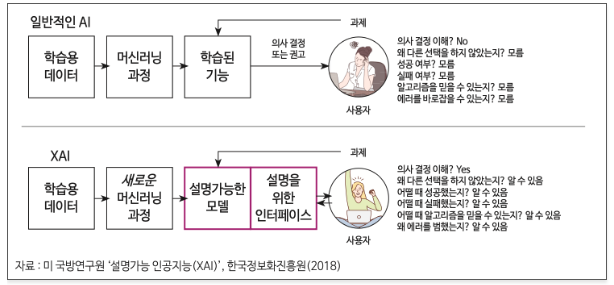

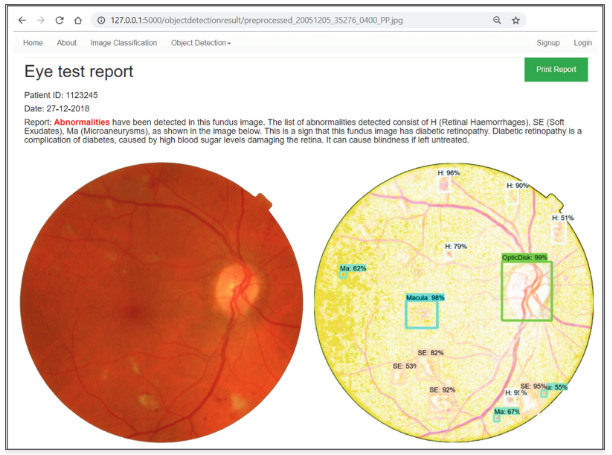

## SHAP vs SAGE

- SHAP
> 각 feature들이 개별 예측에 얼마나 기여를 하였는지?  
>> 각 feature들이 예측 결과에 얼마나 영향을 끼쳤는지?

- SAGE
> 모델 학습 시 각 feature에 얼마나 의존하였는지?  
>> 모델이 학습 할 때 각 feature를 얼마나 확인했는지?

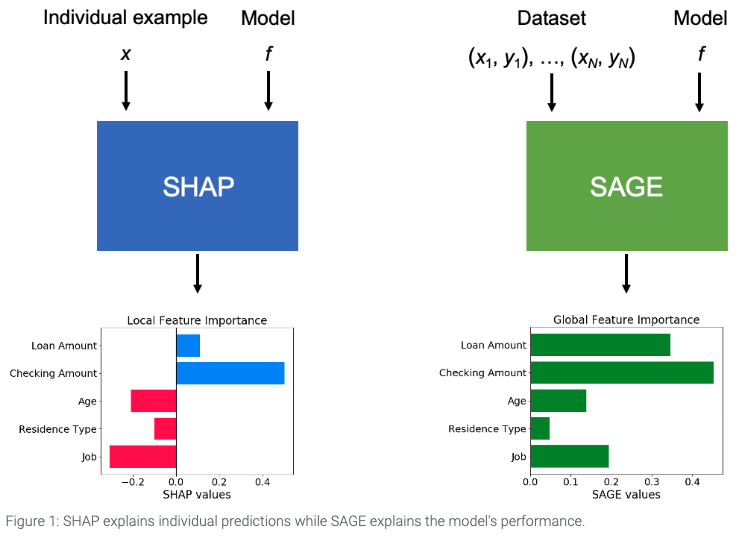

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

df = sns.load_dataset('titanic') # 타이타닉 데이터 받아오기
cols = ["age","sibsp","parch","fare"] # 숫자니까 바로 사용
features = df[cols] # 피쳐
target = df["survived"] # 정답값

In [3]:
# 범주형 데이터 인코딩
from sklearn.preprocessing import OneHotEncoder

cols = ["pclass","sex","embarked"] # 범주형

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features,tmp],axis=1)

In [4]:
features.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan
0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [5]:
# 결측치 제거
features.age = features.age.fillna(features.age.median())

In [6]:
# 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = pd.DataFrame(
    scaler.fit_transform(features),
    columns = features.columns
)

In [7]:
# 데이터 분리
from sklearn.model_selection import KFold, cross_val_score, train_test_split

random_state = 42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20, random_state=random_state
)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

## SAGE(Shapley Addictive Global importancE)

학습

In [8]:
from lightgbm import LGBMClassifier, plot_importance

model = LGBMClassifier(random_state=random_state).fit(X_tr, y_tr)

평가

In [9]:
from sklearn.metrics import roc_auc_score

pred = model.predict_proba(X_te)[:,1]
roc_auc_score(y_te, pred)

0.8821106821106821

중요 파라미터 확인

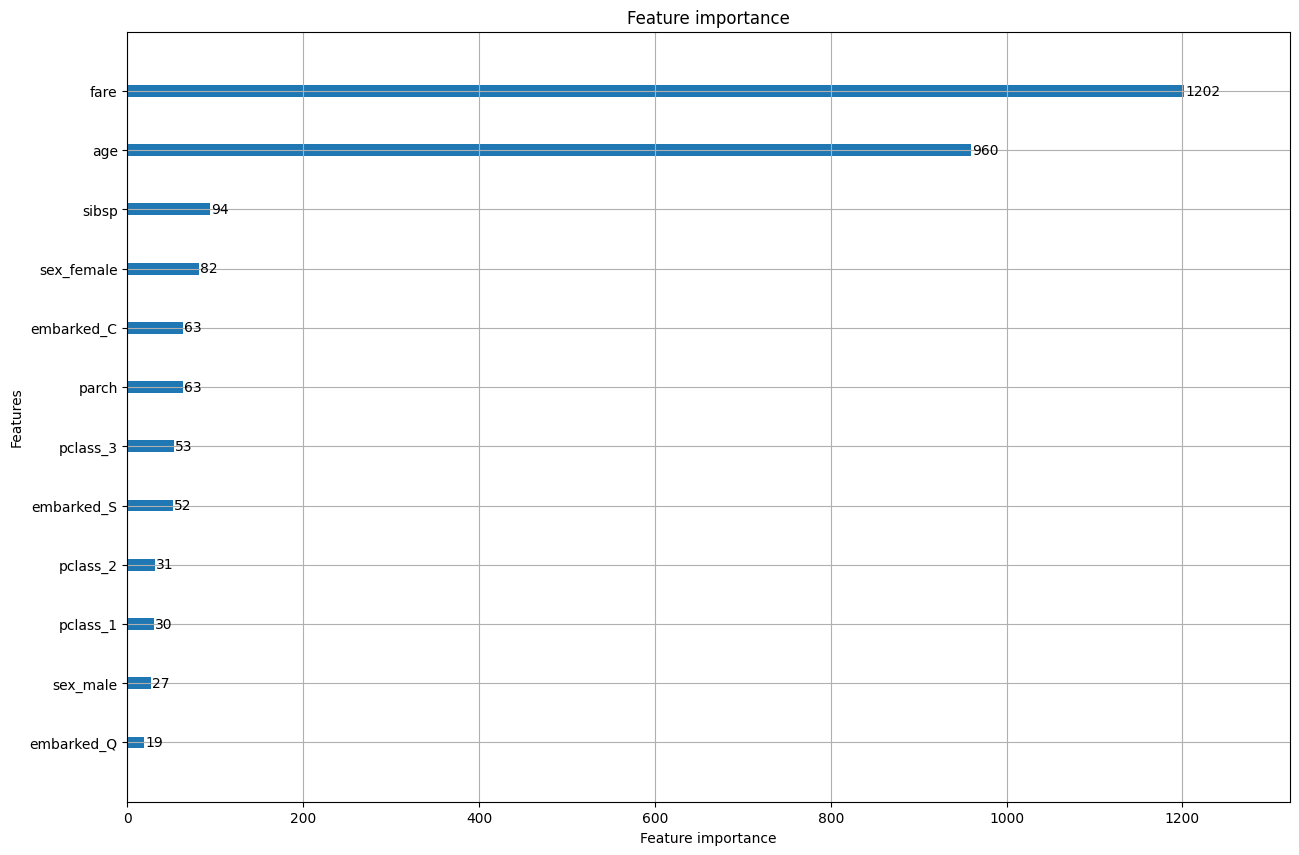

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
plot_importance(model,ax=ax)
plt.show()

## [SHAP(SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html)
- Shapley Value와 feature간 독립성을 핵심 아이디어로 사용하는 기법
- Shapley Value는 게임 이론을 바탕으로 각 feature의 기여도를 계산하는 방법
- SHAP의 목적은 예측에 대한 각 feature의 기여도를 계산하여 관측치(X)의 예측값을 설명하는 것

In [11]:
import shap

In [12]:
explainer = shap.TreeExplainer(model) # 학습된 모델을 넣는다.
shap_values = explainer.shap_values(X_te)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [29]:
shap_values[1].shape, X_te.shape

((179, 13), (179, 13))

In [34]:
shap_values[1][-1,:]

array([ 2.79190297, -0.04813272,  0.308012  ,  1.10207723, -0.04112623,
       -0.03779443, -0.96037182,  1.08411172,  0.04486562, -0.01765551,
        0.01193613, -0.20392933,  0.        ])

force_plot

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][-1,:], X_te.iloc[-1,:])

summary_plot

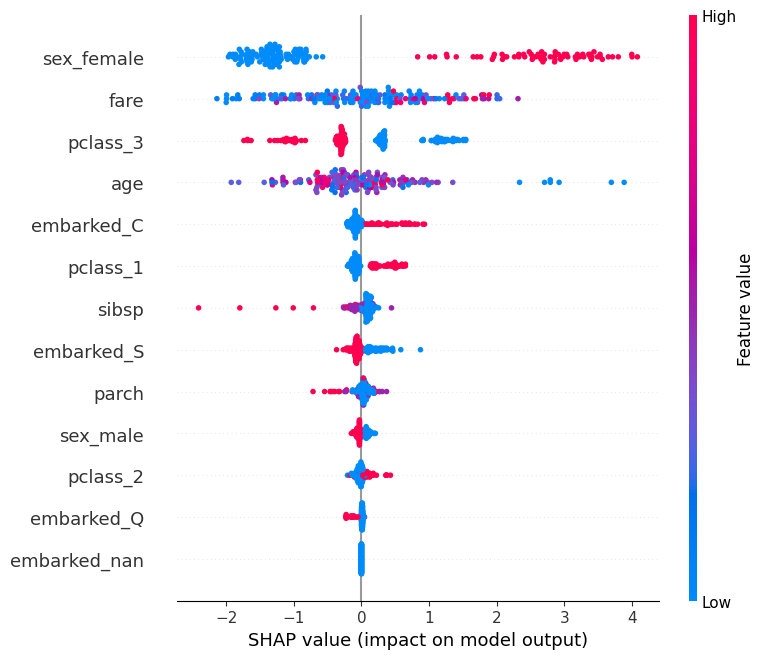

In [17]:
shap.summary_plot(shap_values[1], X_te)

dependence_plot

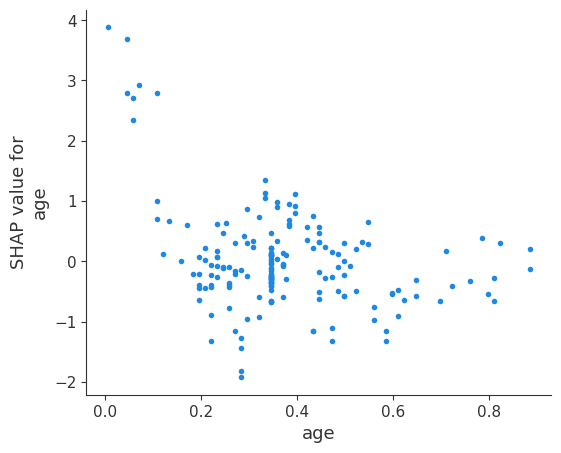

In [18]:
shap.dependence_plot("age", shap_values[1], X_te, interaction_index=None)

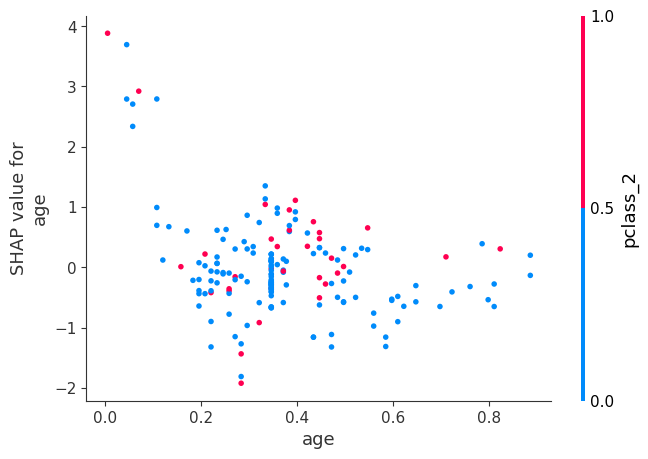

In [27]:
shap.dependence_plot("age",shap_values[1],X_te,interaction_index="auto")

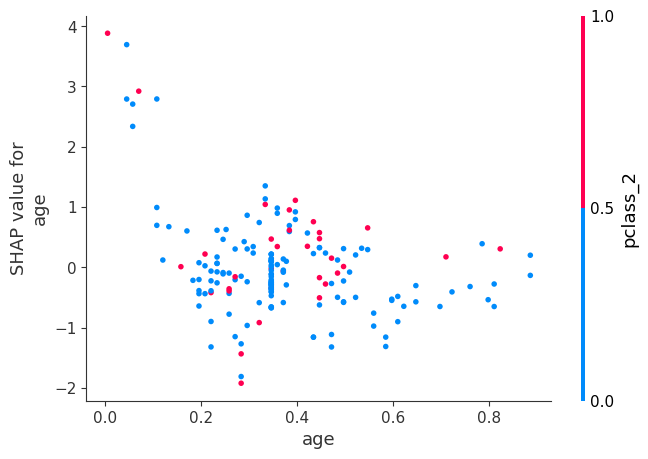

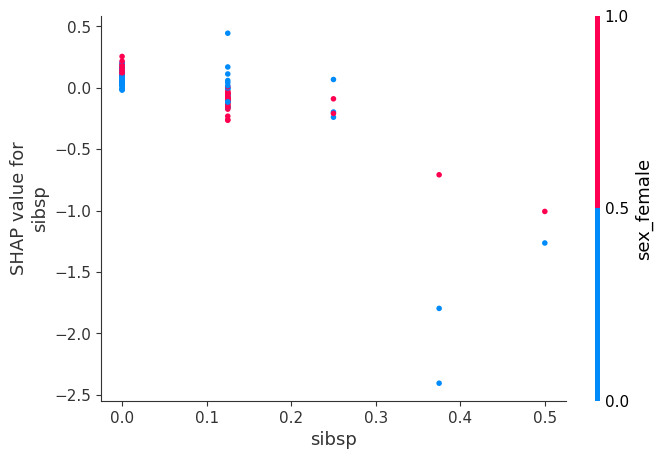

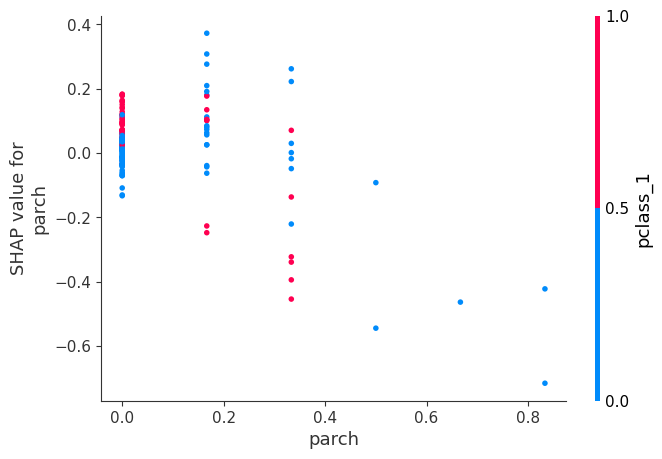

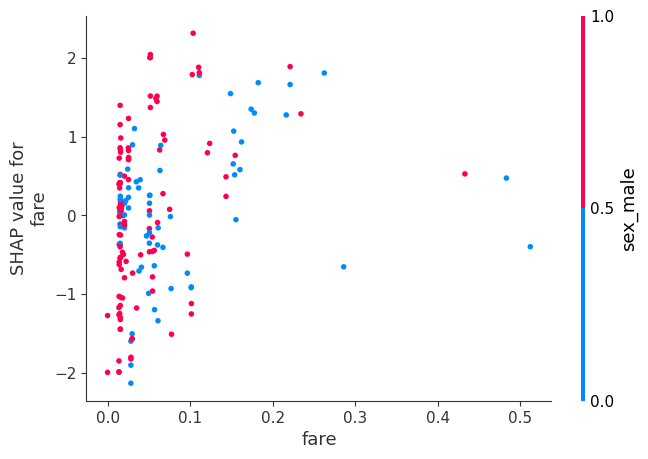

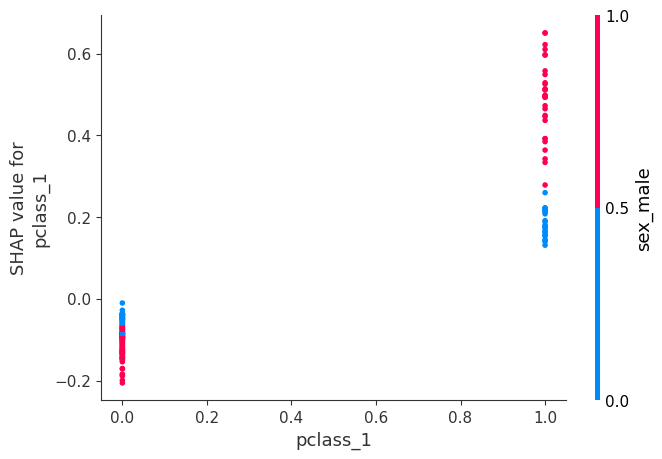

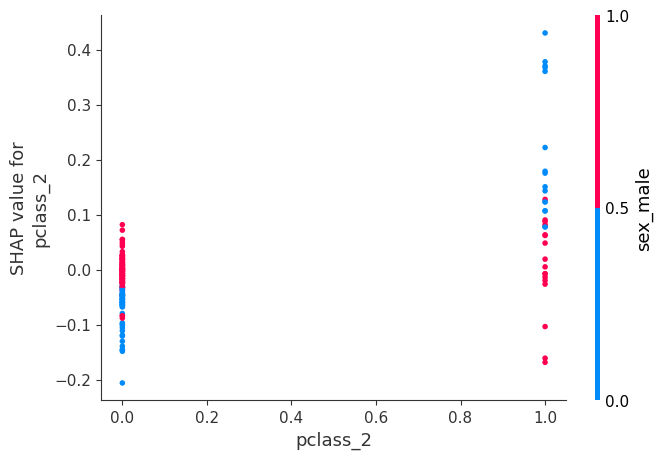

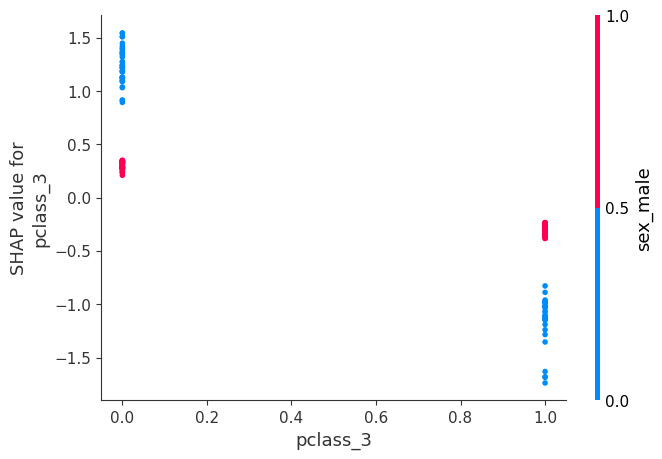

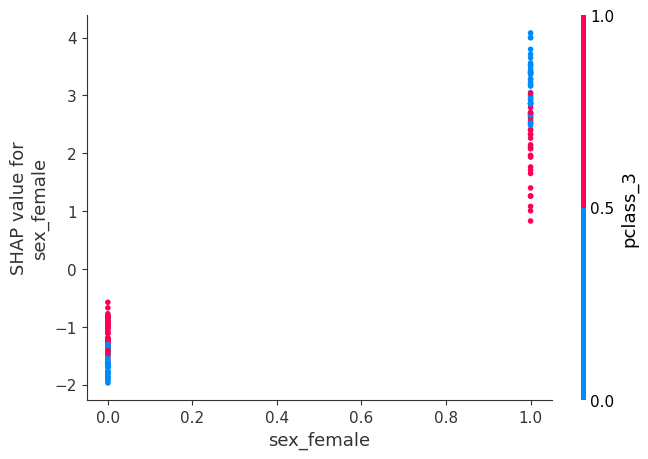

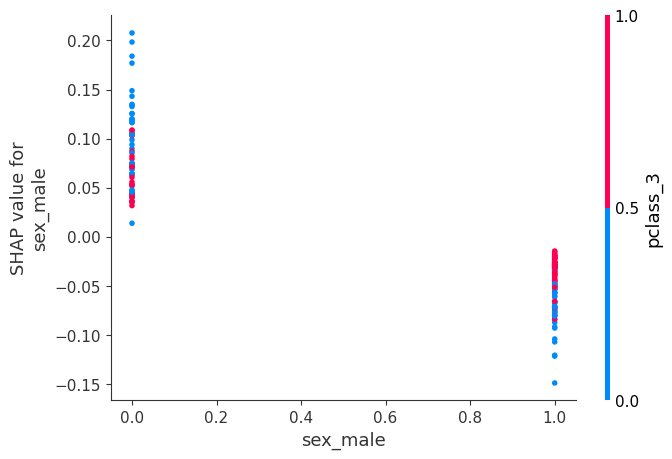

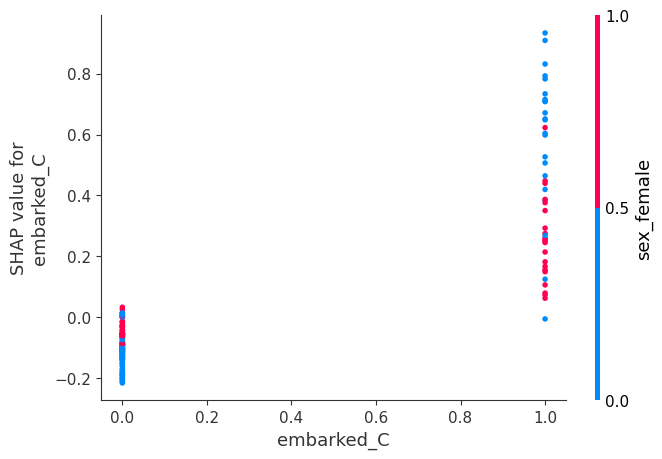

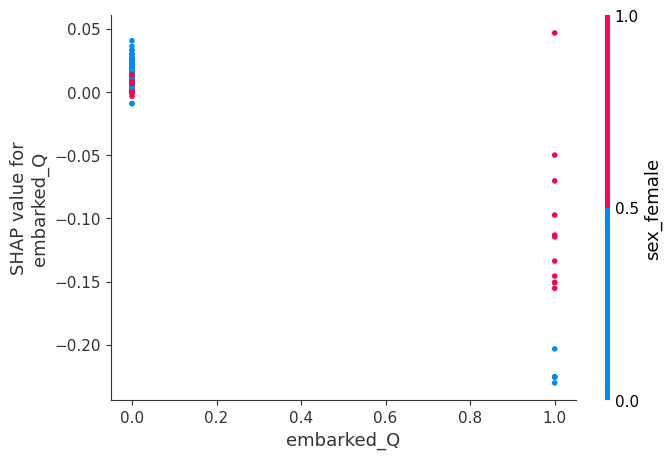

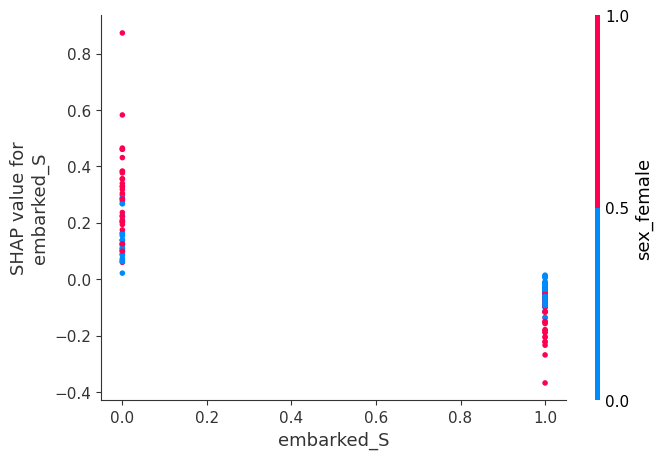

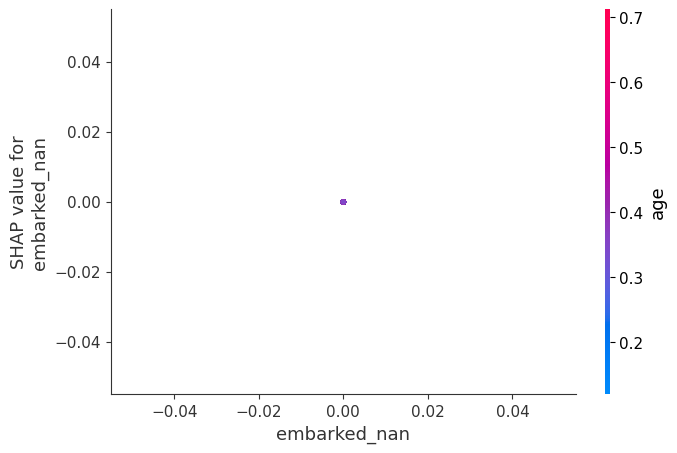

In [28]:
for col in X_te.columns:
    shap.dependence_plot(col,shap_values[1],X_te)